# Portfolio Optimization for Midwits



See [README.md](https://github.com/druce/portfolio_optimization/blob/master/README.md) for discussion, environment setup

todo: in plot_efrontier, take assets df


In [1]:
import time
# import urllib3
from collections import namedtuple
from multiprocessing import Pool

from typing import Callable, List, Any, Tuple
from typing import Optional, Union
import numpy.typing as npt

import numpy as np
import pandas as pd
import pandas_datareader as pdr

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import cvxpy as cp

# Set seed for reproducibility
np.random.seed(42)

# Display versions
print(f"{'numpy':<20} {np.__version__}")
print(f"{'pandas':<20} {pd.__version__}")
print(f"{'pandas-datareader':<20} {pdr.__version__}")
print(f"{'seaborn':<20} {sns.__version__}")
print(f"{'matplotlib':<20} {matplotlib.__version__}")
print(f"{'cvxpy':<20} {cp.__version__}")


numpy                2.3.5
pandas               2.3.3
pandas-datareader    0.10.0
seaborn              0.13.2
matplotlib           3.10.7
cvxpy                1.7.3


# Helper Functions


In [2]:
def fetch_with_retry(fetch_func: Callable[[], Any], max_retries: int = 3, delay: int = 2) -> Any:
    """
    Fetch data with retry logic.

    Attempts to execute the provided fetch function with automatic retries
    on failure, using exponential backoff between attempts.

    Parameters
    ----------
    fetch_func : Callable[[], Any]
        Function that fetches data (takes no arguments)
    max_retries : int, default=3
        Maximum number of retry attempts
    delay : int, default=2
        Delay in seconds between retries

    Returns
    -------
    Any
        Result returned by fetch_func

    Raises
    ------
    Exception
        Re-raises the last exception if all retry attempts fail
    """
    for attempt in range(max_retries):
        try:
            return fetch_func()
        except Exception as e:
            if attempt == max_retries - 1:
                raise
            print(f"Attempt {attempt + 1} failed: {e}. Retrying in {delay}s...")
            time.sleep(delay)


def validate_data(df: pd.DataFrame, required_columns: List[str]) -> None:
    """
    Validate DataFrame has required columns and no NaN/Inf values.

    Checks for missing columns, NaN values, and infinite values in the
    specified columns of the DataFrame.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame to validate
    required_columns : List[str]
        List of required column names to check

    Returns
    -------
    None

    Raises
    ------
    ValueError
        If required columns are missing, NaN values are found, or
        infinite values are detected
    """
    # Check for missing columns
    missing = set(required_columns) - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")

    # Check for NaN values
    if df[required_columns].isna().any().any():
        nan_cols = df[required_columns].columns[df[required_columns].isna().any()].tolist()
        n_missing = df[required_columns].isna().sum()
        raise ValueError(f"Warning: {n_missing} NaN values found in columns: {nan_cols}")

    # Check for infinite values
    if np.isinf(df[required_columns].values).any():
        raise ValueError("Infinite values found in data")

OptimizationResult = namedtuple('OptimizationResult', ['return_val', 'std_dev', 'weights'])

def solve_portfolio_optimization(params: Tuple[float, npt.NDArray[np.float64], npt.NDArray[np.float64], int]) -> OptimizationResult:
    """
    Solve portfolio optimization for given parameters using convex optimization.

    Minimizes portfolio volatility subject to return constraint and long-only
    constraint (standard Markowitz formulation). This is a standalone function
    that can be pickled for multiprocessing.

    Parameters
    ----------
    params : Tuple[float, npt.NDArray[np.float64], npt.NDArray[np.float64], int]
        Tuple containing (target_ret, mu, Sigma, n) where:
        - target_ret : float - Target return constraint
        - mu : npt.NDArray[np.float64] - Expected returns vector
        - Sigma : npt.NDArray[np.float64] - Covariance matrix
        - n : int - Number of assets

    Returns
    -------
    OptimizationResult
        Named tuple with fields:
        - return_val : float - Optimized portfolio return
        - std_dev : float - Portfolio standard deviation
        - weights : npt.NDArray[np.float64] - Asset weights

    Raises
    ------
    ValueError
        If optimization fails, returns None values, or weights don't sum to 1.0
    """
    target_ret, mu, Sigma, n = params

    # Create optimization variables and problem
    w = cp.Variable(n)
    ret = mu.T @ w
    vol = cp.quad_form(w, Sigma)

    prob = cp.Problem(
        cp.Minimize(vol),
        [cp.sum(w) == 1, w >= 0, ret >= target_ret]
    )

    result = prob.solve()

    if prob.status not in ['optimal', 'optimal_inaccurate']:
        raise ValueError(
                 f"Optimization failed with status '{prob.status}' for target_return={target_ret}. "
                 f"Problem may be infeasible or solver encountered an error."
             )

    # Validate results exist
    if ret.value is None or vol.value is None or w.value is None:
        raise ValueError(f"Optimization returned None values for target_return={target_ret}.")

    # Validate weights sum to 1.0 (within numerical precision)
    weight_sum = w.value.sum()
    if abs(weight_sum - 1.0) > WEIGHT_SUM_TOLERANCE:
        raise ValueError(f"Weights sum to {weight_sum:.6f}, not 1.0. Check constraints.")

    return OptimizationResult(
        return_val=ret.value,
        std_dev=np.sqrt(vol.value),
        weights=w.value
    )

def compute_historical_metrics(df: pd.DataFrame, weights: npt.NDArray[np.float64], geometric: bool = False) -> Tuple[float, float]:
    # Compute historical portfolio returns (time series of annual returns)
    portfolio_returns = df @ weights

    if geometric:
        # Geometric mean (CAGR): (product of (1 + r))^(1/n) - 1
        mean_return = (np.prod(1 + portfolio_returns) ** (1 / len(portfolio_returns))) - 1
    else:
        mean_return = portfolio_returns.mean()

    return mean_return, portfolio_returns.std()

def add_historical_metrics(ret_df: pd.DataFrame, df: pd.DataFrame, asset_columns: List[str]) -> pd.DataFrame:
    """
    Add historical return and standard deviation columns based on actual portfolio performance.

    Computes what each efficient frontier portfolio would have actually returned
    historically, using geometric mean (CAGR) and standard deviation of percentage returns.
    Adds 'hist_return' and 'hist_std' columns to the input DataFrame.

    Parameters
    ----------
    ret_df : pd.DataFrame
        Efficient frontier results with model-based returns and asset weight columns
    df : pd.DataFrame
        Historical percentage returns data (for validation/plotting)
    asset_columns : List[str]
        Asset column names in order matching the weights in ret_df

    Returns
    -------
    pd.DataFrame
        Copy of ret_df with added columns:
        - hist_return : float - Geometric mean (CAGR) of portfolio returns
        - hist_std : float - Standard deviation of percentage portfolio returns
    """
    hist_returns = []
    hist_stds = []

    for i in ret_df.index:
        weights = ret_df.loc[i, asset_columns].values
        mean_return, std_dev = compute_historical_metrics(df[asset_columns], weights, geometric=True)
        hist_returns.append(mean_return)
        hist_stds.append(std_dev)

    ret_df = ret_df.copy()
    ret_df['hist_return'] = hist_returns
    ret_df['hist_std'] = hist_stds

    return ret_df

In [3]:
PortfolioMetrics = namedtuple('PortfolioMetrics', ['max_sharpe_return', 'max_sharpe_std', 'avg_ef_return', 'avg_ef_std'])

def plot_efrontier(plot_ef_df: pd.DataFrame,
                   plot_returns_df: pd.DataFrame,
                   assets_df: pd.DataFrame,
                   xlabel: str = "Standard Deviation of Real Returns",
                   ylabel: str = "Real Return",
                   title: Optional[str] = None,
                   risk_free_rate: float = 0) -> PortfolioMetrics:
    """
    Plot efficient frontier with individual assets and key portfolios.

    Creates a visualization of the efficient frontier showing the risk-return
    tradeoff, individual asset positions, maximum Sharpe ratio portfolio, and
    average efficient frontier portfolio. Prints detailed statistics for key
    portfolios.

    Parameters
    ----------
    plot_ef_df : pd.DataFrame
        Efficient frontier scenarios with columns:
        - Asset weight columns (one per asset)
        - 'hist_return' : historical portfolio returns
        - 'hist_std' : historical portfolio standard deviation
    plot_returns_df : pd.DataFrame
        Historical asset returns data with asset columns
    xlabel : str, default="Standard Deviation of Real Returns"
        X-axis label for the plot
    ylabel : str, default="Real Return"
        Y-axis label for the plot
    title : Optional[str], default=None
        Plot title. If None, auto-generated from date range in df
    risk_free_rate : float, default=0
        Risk-free rate for Sharpe ratio calculation

    Returns
    -------
    PortfolioMetrics
        Named tuple with fields:
        - max_sharpe_return : float - Return of max Sharpe ratio portfolio
        - max_sharpe_std : float - Std dev of max Sharpe ratio portfolio
        - avg_ef_return : float - Mean return of average EF portfolio
        - avg_ef_std : float - Std dev of average EF portfolio

    Notes
    -----
    - Calculates Sharpe ratios for all portfolios on efficient frontier
    - Highlights maximum Sharpe ratio portfolio with red star marker
    - Shows average efficient frontier portfolio with green circle marker
    - Displays individual asset positions as gray dots
    - Prints portfolio weights for assets with >0.1% allocation
    """

    asset_labels = list(assets_df.index)

    mu = assets_df['ret'].values
    asset_vols = assets_df['std'].tolist()

    plot_ef_df["Sharpe"] = np.where(
        plot_ef_df["hist_std"] > MIN_VOL_FOR_SHARPE,  # Avoid division by near-zero
        (plot_ef_df["hist_return"] - risk_free_rate) / plot_ef_df["hist_std"],
        np.nan  # Return NaN for zero volatility
    )

    # Find max Sharpe portfolio
    max_sharpe_index = plot_ef_df["Sharpe"].idxmax()
    max_sharpe_return = plot_ef_df.loc[max_sharpe_index, "hist_return"]
    max_sharpe_std = plot_ef_df.loc[max_sharpe_index, "hist_std"]
    max_sharpe_ratio = plot_ef_df.loc[max_sharpe_index, "Sharpe"]

    # Find 'midwit' portfolio averaging weights over whole frontier

    def compute_historical_metrics(df: pd.DataFrame, weights: npt.NDArray[np.float64]) -> Tuple[float, float]:
        # Compute historical portfolio returns (time series of annual returns)
        portfolio_returns = df @ weights
        return portfolio_returns.mean(), portfolio_returns.std()

    mean_wts = plot_ef_df[asset_labels].mean()
    ret_series = plot_returns_df[asset_labels] @ mean_wts.values
    avg_ret_mean = (ret_series + 1).prod() ** (1/len(ret_series)) - 1
    avg_ret_std = ret_series.std()

    # Create plot
    plt.figure(figsize=(8, 4.5))

    # Plot efficient frontier
    plt.plot(plot_ef_df['hist_std'], plot_ef_df['hist_return'], label='Efficient frontier', linewidth=2)

    plt.xlim(left=0, right=max(asset_vols) * 1.05)
    plt.ylim(bottom=min(0, min(mu)))

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # fix df
    plot_title = f"Risk vs. Real Return, {df.index[0]}-{df.index[-1]}" if title is None else title
    plt.title(plot_title)

    # Plot individual assets
    plt.scatter(asset_vols, mu, color='gray', s=50, zorder=5)
    xoffset = 0.0025
    yoffset = 0.0015

    for i, label in enumerate(asset_labels):
        plt.annotate(label, xy=(asset_vols[i] + xoffset, mu[i] + yoffset),
                    xycoords='data', horizontalalignment='left',
                    verticalalignment='top')


    # Plot max Sharpe portfolio (model)
    plt.scatter([max_sharpe_std], [max_sharpe_return], color='red', s=100,
               marker='*', label='Max Sharpe', zorder=10)
    plt.annotate("Max Sharpe", xy=(max_sharpe_std + xoffset, max_sharpe_return + yoffset),
                xycoords='data', horizontalalignment='left',
                verticalalignment='top', fontsize=9)

    # Plot average EF portfolio
    plt.scatter([avg_ret_std], [avg_ret_mean], color='green', s=80,
               marker='o', label='EF Avg Wts', zorder=10)
    plt.annotate("EF Avg Wts", xy=(avg_ret_std + xoffset, avg_ret_mean + yoffset),
                xycoords='data', horizontalalignment='left',
                verticalalignment='top', fontsize=9)

    plt.legend(loc='best')
    plt.grid(alpha=0.3)
    plt.show()

    # Print statistics
    print("="*60)
    print("Max Sharpe Portfolio:")
    print(f"Real Return:  {100 * max_sharpe_return:3.2f}%")
    print(f"SD:           {100 * max_sharpe_std:3.2f}%")
    print(f"Sharpe Ratio: {max_sharpe_ratio:3.3f}")
    for col in asset_labels:
        wt = plot_ef_df.loc[max_sharpe_index, col]
        if wt > MIN_DISPLAY_WEIGHT:
            print(f"{col}: {100*wt:3.1f}%")

    print("="*60)
    print("Average over entire efficient frontier:")
    print(f"Real Return:  {100 * avg_ret_mean:3.2f}%")
    print(f"SD:           {100 * avg_ret_std:3.2f}%")
    print(f"Sharpe Ratio: {avg_ret_mean / avg_ret_std:3.3f}")
    for col in asset_labels:
        wt = mean_wts[col]
        if wt > MIN_DISPLAY_WEIGHT:
            print(f"{col}: {100*wt:3.1f}%")
    print("="*60)

    return PortfolioMetrics(
        max_sharpe_return=max_sharpe_return,
        max_sharpe_std=max_sharpe_std,
        avg_ef_return=avg_ret_mean,
        avg_ef_std=avg_ret_std
    )


In [4]:
# stacked area chart of weights vs. returns
# for given vol constraint and corresponding real return, show portfolio weights
def transition_map(ret_df: pd.DataFrame, asset_labels: Union[List[str], pd.Index],
                  startyear: int, endyear: int,
                  max_sharpe_return: Optional[float] = None, ylim: float = 1) -> None:
    """
    Create transition map showing portfolio weights across return levels.

    Displays a stacked area chart showing how optimal portfolio weights change
    across different target return levels along the efficient frontier.

    Parameters
    ----------
    ret_df : pd.DataFrame
        Efficient frontier results containing asset weight columns and
        'hist_return' column
    asset_labels : Union[List[str], pd.Index]
        Asset column names to display in the transition map
    startyear : int
        Start year for plot title
    endyear : int
        End year for plot title
    max_sharpe_return : Optional[float], default=None
        Return of max Sharpe ratio portfolio. If provided, draws a vertical
        dashed line at this return level
    ylim : float, default=1
        Y-axis upper limit (portfolio weights sum to 1.0)

    Returns
    -------
    None
        Displays matplotlib plot but returns nothing

    Notes
    -----
    - Uses tab20 colormap for up to 10 assets
    - X-axis shows portfolio return levels
    - Y-axis shows portfolio weight allocation (0 to ylim)
    - Stacked areas show weight allocation to each asset
    """
    x = ret_df['hist_return']
    y_list = [ret_df[label] for label in asset_labels]

    # Generate colors dynamically based on number of assets
    colors = cm.tab20.colors[:len(asset_labels)]

    fig = plt.figure(figsize=(8, 4.5))
    ax1 = fig.add_subplot(111)

    ax1.stackplot(x, y_list, labels=asset_labels, colors=colors)
    ax1.set_xlim((ret_df['hist_return'].iloc[0], ret_df['hist_return'].iloc[-1]))
    ax1.set_ylim((0, ylim))
    ax1.set_xlabel("Portfolio Real Return")
    ax1.set_ylabel("Portfolio Weight")
    ax1.legend(loc='lower right')

    if max_sharpe_return is not None:
        ax1.axvline(max_sharpe_return, color='black', linestyle='--', linewidth=1)

    plt.title(f"Optimal Portfolio Transition Map, {startyear}-{endyear}", y=1.16)
    plt.show()


# Get data

In [5]:
# Data source configuration
DATA_XLS = 'https://www.stern.nyu.edu/~adamodar/pc/datasets/histretSP.xls'
DATA_SHEET = "Returns by year"

# Damodaran data structure constants (as of 2025)
DAMODARAN_HEADER_ROWS = 19  # Rows before data starts
DAMODARAN_FOOTER_ROWS = 13  # Footnote rows at end

# Manual GDP data for years not in FRED (source: fortunly.com)
MANUAL_GDP_DATA = {
    1928: 0.0110,
    1929: 0.0652,
}

# Optimization parameters
NPOINTS = 200  # Points on efficient frontier
USE_PARALLEL = False  # Enable parallel processing, doesn't work under Jupyter
NPROCESSES = 8  # Number of parallel processes

# Other constants
WEIGHT_SUM_TOLERANCE = 1e-4
MIN_VOL_FOR_SHARPE = 1e-10
MIN_DISPLAY_WEIGHT = 0.001


In [6]:
# Load spreadsheet from Damodaran website

# Disable SSL certificate verification if necessary
# previously noticed this issue with the Damodaran website
# urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

download_df = fetch_with_retry(
    lambda: pd.read_excel(
        DATA_XLS,
        sheet_name=DATA_SHEET,
        skiprows=range(DAMODARAN_HEADER_ROWS),
        skipfooter=DAMODARAN_FOOTER_ROWS
    )
)

download_df.head()

,Year,S&P 500 (includes dividends),US Small cap (bottom decile),3-month T.Bill,US T. Bond (10-year),Baa Corporate Bond,Real Estate,Gold*,S&P 500 (includes dividends)3,US Small cap (bottom decile) Cum Value,...,Gold,S&P 500 (includes dividends)3.1,US Small cap (bottom decile)22.1,3-month T.Bill4.1,US T. Bond5.1,Baa Corporate Bond2.1,Real Estate2.1,Gold2.1,Stocks minus T. Bills,Stocks minus T.Bonds
0,1928,0.438112,0.5991,0.0308,0.008355,0.032196,0.014911,0.000969,143.811155,159.910000,...,0.012676,145.493158,161.780293,104.285615,102.014834,104.426798,102.678084,101.267624,0.412075,0.434783
1,1929,-0.082979,-0.4661,0.0316,0.042038,0.030179,-0.020568,-0.001452,131.877782,85.375949,...,-0.007258,132.644508,85.872317,106.955564,105.685290,106.952789,99.981502,100.532660,-0.113913,-0.124291
2,1930,-0.251236,-0.5003,0.0455,0.045409,0.005398,-0.043000,0.000969,98.745288,42.662362,...,0.069359,106.105182,45.842164,119.462059,118.033011,114.876878,102.219599,107.505474,-0.317010,-0.316913
3,1931,-0.438375,-0.4466,0.0231,-0.025589,-0.156808,-0.081505,-0.173850,55.457774,23.609351,...,-0.088971,65.713662,27.975463,134.778649,126.829091,106.815001,103.534271,97.940557,-0.508887,-0.455197
4,1932,-0.086424,0.2049,0.0107,0.087903,0.235896,-0.104664,0.212778,50.664911,28.446907,...,0.351646,66.908619,37.567287,151.818576,153.776732,147.128135,103.312182,132.380976,-0.108245,-0.194288


In [7]:
# set index to year as int
download_df["Year"] = download_df["Year"].astype(int)
download_df = download_df.set_index(download_df["Year"])
download_df


,Year,S&P 500 (includes dividends),US Small cap (bottom decile),3-month T.Bill,US T. Bond (10-year),Baa Corporate Bond,Real Estate,Gold*,S&P 500 (includes dividends)3,US Small cap (bottom decile) Cum Value,...,Gold,S&P 500 (includes dividends)3.1,US Small cap (bottom decile)22.1,3-month T.Bill4.1,US T. Bond5.1,Baa Corporate Bond2.1,Real Estate2.1,Gold2.1,Stocks minus T. Bills,Stocks minus T.Bonds
Year,,,,,,,,,,,,,,,,,,,,,
1928,1928,0.438112,0.5991,0.030800,0.008355,0.032196,0.014911,0.000969,143.811155,1.599100e+02,...,0.012676,145.493158,161.780293,104.285615,102.014834,104.426798,102.678084,101.267624,0.412075,0.434783
1929,1929,-0.082979,-0.4661,0.031600,0.042038,0.030179,-0.020568,-0.001452,131.877782,8.537595e+01,...,-0.007258,132.644508,85.872317,106.955564,105.685290,106.952789,99.981502,100.532660,-0.113913,-0.124291
1930,1930,-0.251236,-0.5003,0.045500,0.045409,0.005398,-0.043000,0.000969,98.745288,4.266236e+01,...,0.069359,106.105182,45.842164,119.462059,118.033011,114.876878,102.219599,107.505474,-0.317010,-0.316913
1931,1931,-0.438375,-0.4466,0.023100,-0.025589,-0.156808,-0.081505,-0.173850,55.457774,2.360935e+01,...,-0.088971,65.713662,27.975463,134.778649,126.829091,106.815001,103.534271,97.940557,-0.508887,-0.455197
1932,1932,-0.086424,0.2049,0.010700,0.087903,0.235896,-0.104664,0.212778,50.664911,2.844691e+01,...,0.351646,66.908619,37.567287,151.818576,153.776732,147.128135,103.312182,132.380976,-0.108245,-0.194288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,2020,0.180232,0.3473,0.003547,0.113319,0.106012,0.104266,0.241694,592914.798591,4.306129e+06,...,0.225009,39379.864970,286001.909604,139.282860,592.503127,3531.986222,266.622464,608.536643,0.174310,0.066014
2021,2021,0.284689,0.2169,0.000450,-0.044160,0.009334,0.188646,-0.037544,761710.833617,5.240128e+06,...,-0.100815,47265.098928,325156.417627,130.185213,529.107841,3330.600950,296.085994,547.187283,0.265553,0.307231
2022,2022,-0.180375,-0.2338,0.020248,-0.178282,-0.151441,0.056518,0.005494,624317.196856,4.014986e+06,...,-0.055470,36390.843316,234029.638217,124.768141,408.416737,2654.857034,293.853809,516.835040,-0.188459,-0.001966


In [8]:
# Download GDP data from FRED
gdp_download = fetch_with_retry(
    lambda: pdr.data.DataReader(['GDPCA'], 'fred', start='1926-12-31')
)

gdp_download.reset_index(inplace=True)
gdp_download.set_index(pd.DatetimeIndex(gdp_download['DATE']).year, inplace=True)
gdp_download['GDP'] = gdp_download['GDPCA'].pct_change()

# Fill in manual GDP data for early years
for year, value in MANUAL_GDP_DATA.items():
    gdp_download.loc[year, 'GDP'] = value

gdp_download.sort_index(inplace=True)
gdp_download.to_csv('gdp_fred.csv')

gdp_download

,DATE,GDPCA,GDP
DATE,,,
1928,NaT,NaN,0.011000
1929,1929-01-01,1191.124,0.065200
1930,1930-01-01,1089.785,-0.085078
1931,1931-01-01,1019.977,-0.064057
1932,1932-01-01,888.414,-0.128986
...,...,...,...
2020,2020-01-01,20284.500,-0.020814
2021,2021-01-01,21532.407,0.061520
2022,2022-01-01,22075.931,0.025242


In [9]:
# Preview columns
print("Available columns:")
for col in download_df.columns:
    print(f"  {col}")


Available columns:
  Year
  S&P 500 (includes dividends)
  US Small cap (bottom decile)
  3-month T.Bill
  US T. Bond (10-year)
   Baa Corporate Bond
  Real Estate
  Gold*
  S&P 500 (includes dividends)3
  US Small cap (bottom decile) Cum Value
  3-month T.Bill4
  US T. Bond5
   Baa Corporate Bond2
  Real Estate2
  Gold2
  Stocks - Bills
  Stocks - Bonds
  Small Cap Premium (S&P 500 minus Bottom Decile)
  Stocks - Baa Corp Bond
  Historical ERP
  Inflation Rate
  S&P 500 (includes dividends)2
  US Small cap (bottom decile)22
  3-month T. Bill (Real)
  !0-year T.Bonds
  Baa Corp Bonds
  Real Estate3
  Gold
  S&P 500 (includes dividends)3.1
  US Small cap (bottom decile)22.1
  3-month T.Bill4.1
  US T. Bond5.1
   Baa Corporate Bond2.1
  Real Estate2.1
  Gold2.1
  Stocks minus T. Bills
  Stocks minus T.Bonds


In [10]:
# Extract and rename columns for real returns
# Note: Column names may have quirky characters in source (e.g., '!0-year' instead of '10-year')

plot_returns_df = download_df.copy()

# Drop nominal real estate column to avoid confusion
if "Real Estate" in plot_returns_df.columns:
    plot_returns_df = plot_returns_df.drop(columns=["Real Estate"])

# Define column rename mapping
rename_map = {
    'Inflation Rate': 'CPI',
    'S&P 500 (includes dividends)2': 'S&P',
    "US Small cap (bottom decile)22": "Small Caps",
    '3-month T. Bill (Real)': 'T-Bills',
    '!0-year T.Bonds': 'T-Notes',
    'Baa Corp Bonds': 'Baa Corps',
    'Real Estate3': 'Real Estate',
}

# Check if all names in rename_map are present in columns
missing_names = set(rename_map.keys()) - set(plot_returns_df.columns)
if missing_names:
    raise ValueError(f"Names {missing_names} not found in real_return_df columns")

# Rename columns
plot_returns_df = plot_returns_df.rename(columns=rename_map)

# Add GDP data
plot_returns_df["GDP"] = gdp_download['GDP']

# Select, reorder columns, and validate data
required_columns = ['GDP', 'CPI', 'S&P', 'Small Caps', 'T-Bills',
                   'T-Notes', 'Baa Corps', 'Real Estate', 'Gold']

validate_data(plot_returns_df, required_columns)
plot_returns_df = plot_returns_df[required_columns]

plot_returns_df


,GDP,CPI,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
Year,,,,,,,,,
1928,0.011000,-0.011561,0.454932,0.617803,0.042856,0.020148,0.044268,0.026781,0.012676
1929,0.065200,0.005848,-0.088311,-0.469204,0.025602,0.035980,0.024189,-0.026262,-0.007258
1930,-0.085078,-0.063953,-0.200079,-0.466159,0.116932,0.116835,0.074090,0.022385,0.069359
1931,-0.064057,-0.093168,-0.380674,-0.389744,0.128213,0.074522,-0.070178,0.012861,-0.088971
1932,-0.128986,-0.102740,0.018184,0.342866,0.126429,0.212472,0.377411,-0.002145,0.351646
...,...,...,...,...,...,...,...,...,...
2020,-0.020814,0.013620,0.164373,0.329196,-0.009937,0.098359,0.091150,0.089428,0.225009
2021,0.061520,0.070364,0.200235,0.136903,-0.065318,-0.106996,-0.057018,0.110507,-0.100815
2022,0.025242,0.064544,-0.230069,-0.280255,-0.041611,-0.228103,-0.202889,-0.007539,-0.055470


In [11]:
# calculate total return indexes
total_return_index_df = (plot_returns_df+1).cumprod()
total_return_index_df.loc[1927] = 1
total_return_index_df = total_return_index_df.sort_index()
total_return_index_df

,GDP,CPI,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
Year,,,,,,,,,
1927,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1928,1.011000,0.988439,1.454932,1.617803,1.042856,1.020148,1.044268,1.026781,1.012676
1929,1.076917,0.994220,1.326445,0.858723,1.069556,1.056853,1.069528,0.999815,1.005327
1930,0.985295,0.930636,1.061052,0.458422,1.194621,1.180330,1.148769,1.022196,1.075055
1931,0.922180,0.843931,0.657137,0.279755,1.347786,1.268291,1.068150,1.035343,0.979406
...,...,...,...,...,...,...,...,...,...
2020,18.339591,15.056293,393.798650,2860.019096,1.392829,5.925031,35.319862,2.666225,6.085366
2021,19.467847,16.115714,472.650989,3251.564176,1.301852,5.291078,33.306010,2.960860,5.471873
2022,19.959257,17.155887,363.908433,2340.296382,1.247681,4.084167,26.548570,2.938538,5.168350


In [12]:
# compute log diffs
# if we optimize using % , if a stock goes up 50% and down 50% it is -25% which causes mathematical difficulties
# if we use log diff , start + delta - delta = start
log_diff_df = np.log(total_return_index_df).diff().dropna()
log_diff_df.head()

,GDP,CPI,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
Year,,,,,,,,,
1928,0.010940,-0.011628,0.374959,0.481069,0.041963,0.019948,0.043316,0.026429,0.012597
1929,0.063163,0.005831,-0.092456,-0.633378,0.025280,0.035347,0.023901,-0.026614,-0.007284
1930,-0.088917,-0.066090,-0.223242,-0.627657,0.110585,0.110499,0.071473,0.022138,0.067059
1931,-0.066200,-0.097798,-0.479124,-0.493876,0.120635,0.071876,-0.072763,0.012779,-0.093181
1932,-0.138098,-0.108409,0.018021,0.294806,0.119052,0.192661,0.320205,-0.002147,0.301323


In [13]:
# Compute geometric mean returns
n_periods = len(total_return_index_df) - 1
geometric_mean = pd.DataFrame(total_return_index_df.iloc[-1] ** (1 / n_periods) - 1)
geometric_mean.columns=['Ret']

# Compute std of real_return_df
real_return_std = pd.DataFrame(plot_returns_df.std())
real_return_std.columns=['STD']

# Combine geometric mean and std
geometric_mean = pd.concat([geometric_mean, real_return_std], axis=1)

print("Geometric mean returns with STD:")
geometric_mean


Geometric mean returns with STD:


,Ret,STD
GDP,0.031945,0.047254
CPI,0.030374,0.039154
S&P,0.067000,0.193954
Small Caps,0.084081,0.372102
T-Bills,0.002675,0.038017
T-Notes,0.014209,0.088987
Baa Corps,0.034818,0.088440
Real Estate,0.011557,0.049934
Gold,0.020178,0.186131


# Visualize

In [14]:
pd.set_option('display.max_rows', None)  # display all rows without truncation
pd.set_option('display.float_format', '{:.6f}'.format) # don't use scientific notation


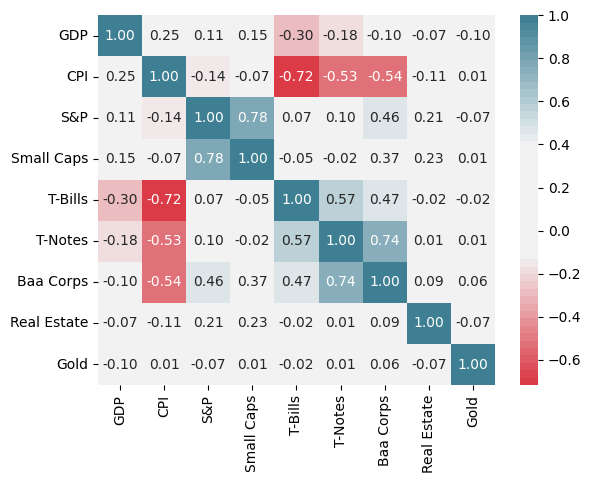

In [15]:
# for col in plot_returns_df.columns:
#     plot_returns_df[col] = plot_returns_df[col].astype(float)

# compute correlation matrix
my_cmap = sns.diverging_palette(10, 220, sep=80, n=50)
sns.heatmap(log_diff_df.corr(), annot=True, fmt=".02f", cmap=my_cmap);


In [16]:
# Drop CPI and GDP - these are not investable assets
labels = [label for label in list(log_diff_df.columns) if label not in ['CPI', 'GDP']]

df = log_diff_df[labels].copy()
df.head()

,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
Year,,,,,,,
1928,0.374959,0.481069,0.041963,0.019948,0.043316,0.026429,0.012597
1929,-0.092456,-0.633378,0.025280,0.035347,0.023901,-0.026614,-0.007284
1930,-0.223242,-0.627657,0.110585,0.110499,0.071473,0.022138,0.067059
1931,-0.479124,-0.493876,0.120635,0.071876,-0.072763,0.012779,-0.093181
1932,0.018021,0.294806,0.119052,0.192661,0.320205,-0.002147,0.301323


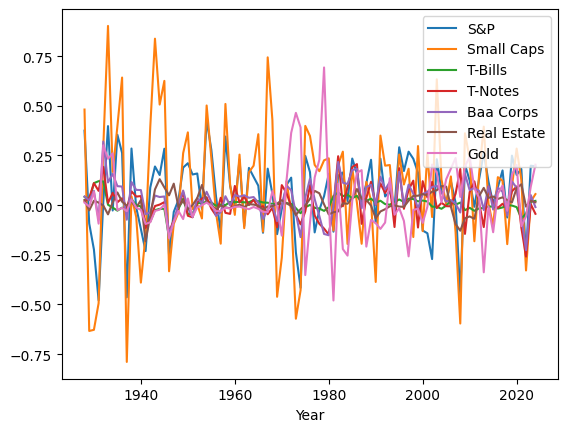

In [17]:
# Plot return series
df.plot.line();


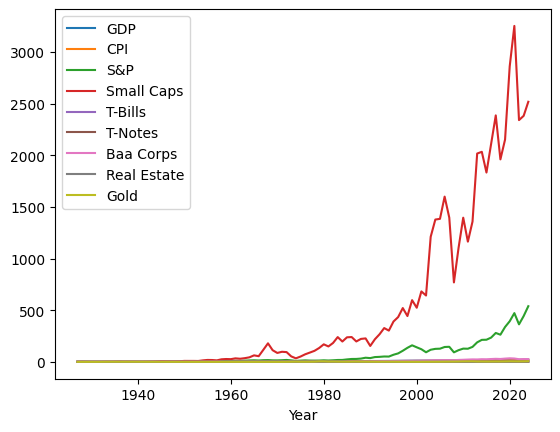

In [18]:
# Plot historical cumulative growth
total_return_index_df.plot.line();


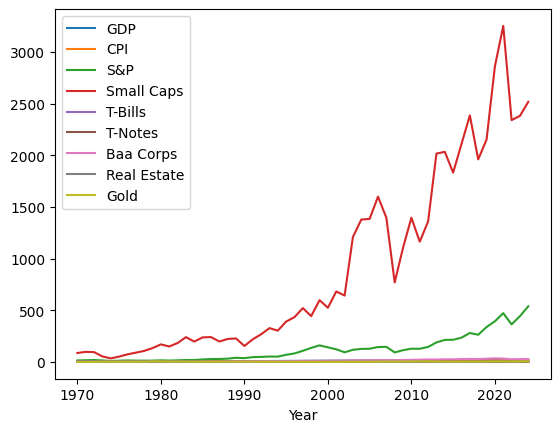

In [19]:
# plot historical cumulative growth since 1970
total_return_index_df.loc[1970:].plot.line();


# Long-only optimization

## 1928 - present 

In [20]:
df.head()


,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
Year,,,,,,,
1928,0.374959,0.481069,0.041963,0.019948,0.043316,0.026429,0.012597
1929,-0.092456,-0.633378,0.025280,0.035347,0.023901,-0.026614,-0.007284
1930,-0.223242,-0.627657,0.110585,0.110499,0.071473,0.022138,0.067059
1931,-0.479124,-0.493876,0.120635,0.071876,-0.072763,0.012779,-0.093181
1932,0.018021,0.294806,0.119052,0.192661,0.320205,-0.002147,0.301323


In [21]:
# Arithmetic means of log diff returns
df.mean()


S&P           0.064851
Small Caps    0.080732
T-Bills       0.002672
T-Notes       0.014109
Baa Corps     0.034225
Real Estate   0.011491
Gold          0.019977
dtype: float64

In [22]:
# Compute covariance matrix and optimization parameters
covariance_matrix = np.cov(df.transpose())
n_assets = covariance_matrix.shape[0]
mean_return = df.mean().values
asset_vols = np.sqrt(covariance_matrix.diagonal())

# Display summary
summary_df = pd.DataFrame([mean_return, asset_vols], columns=labels)
summary_df['metric'] = ['real return', 'volatility']
summary_df.set_index('metric')


,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
metric,,,,,,,
real return,0.064851,0.080732,0.002672,0.014109,0.034225,0.011491,0.019977
volatility,0.191015,0.324757,0.038102,0.087166,0.085182,0.049835,0.165922


In [23]:
# Solve max return portfolio (corner solution, max return asset)
w = cp.Variable(n_assets)
ret = mean_return.T @ w
vol = cp.quad_form(w, covariance_matrix)

prob = cp.Problem(
    cp.Maximize(ret),
    [cp.sum(w) == 1, w >= 0]
)
prob.solve()

if prob.status not in ['optimal', 'optimal_inaccurate']:
    raise ValueError(f"Optimization failed with status: {prob.status}")

wts = [float(f'{v:.4f}') for v in w.value]
_, maxretstd = compute_historical_metrics(df, np.array(wts))
maxretvol = vol.value
print(f"max variance (from weights):      {maxretstd**2}")
print(f"max variance (from optimization): {maxretvol}")
maxret = ret.value

print("Max return portfolio weights:")
pd.DataFrame([wts], columns=labels)

max variance (from weights):      0.10546734625867846
max variance (from optimization): 0.10546734519086332
Max return portfolio weights:


,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [24]:
# Solve min volatility portfolio (other corner solution)
# should be mostly T-bills but there is variance in t-bills so it diversifies

prob = cp.Problem(
    cp.Minimize(vol),
    [cp.sum(w) == 1, w >= 0]
)
prob.solve()

if prob.status not in ['optimal', 'optimal_inaccurate']:
    raise ValueError(f"Optimization failed with status: {prob.status}")

wts = [float(f'{v:.6f}') for v in w.value]
minvol = vol.value
print(f"Minimum vol: {minvol}")
minvolret = ret.value

print("Min volatility portfolio weights:")
pd.DataFrame([wts], columns=labels)


Minimum vol: 0.0008471128533673353
Min volatility portfolio weights:


,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
0,0.000000,0.000000,0.597232,-0.000000,-0.000000,0.360788,0.041979


In [25]:
%%time
# Solve efficient frontier using standard Markowitz formulation
# For each target return level, minimize volatility

# Generate return targets (linear spacing from min to max return)
ret_targets = np.linspace(minvolret, maxret, NPOINTS)

# Prepare parameters for parallel processing
params_list = [(target_ret, mean_return, covariance_matrix, n_assets) for target_ret in ret_targets]

# Solve in parallel or single-thread
if USE_PARALLEL:
    with Pool(processes=NPROCESSES) as pool:
        result_values = pool.map(solve_portfolio_optimization, params_list)
    results_dict = dict(zip(ret_targets, result_values))
else:
    results_dict = {}
    for params in params_list:
        target_ret = params[0]
        results_dict[target_ret] = solve_portfolio_optimization(params)

for target_ret, result in results_dict.items():
      if result is None:
          raise ValueError(f"Optimization failed for target_return={target_ret}")
      if not isinstance(result, OptimizationResult):
          raise ValueError(f"Unexpected result type for target_return={target_ret}")


CPU times: user 344 ms, sys: 7.8 ms, total: 351 ms
Wall time: 351 ms


In [26]:
# Build scenarios DataFrame
plot_ef_df = pd.DataFrame([result.weights for result in results_dict.values()], columns=labels)

plot_ef_df['model_return'] = [result.return_val for result in results_dict.values()]
plot_ef_df['model_std'] = [result.std_dev for result in results_dict.values()]

# Add historical metrics
# plot_ef_df = add_historical_metrics(plot_ef_df, plot_returns_df, labels)
# weights for each asset, plus average return, standard deviation (log diff basis)
plot_ef_df.tail()

,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold,model_return,model_std
195,0.093854,0.906146,0.000000,0.000000,0.000000,0.000000,0.000000,0.079242,0.308483
196,0.070391,0.929609,0.000000,0.000000,0.000000,0.000000,0.000000,0.079614,0.312512
197,0.046927,0.953073,0.000000,0.000000,0.000000,0.000000,0.000000,0.079987,0.316568
198,0.023464,0.976536,0.000000,0.000000,0.000000,0.000000,0.000000,0.080360,0.320650
199,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080732,0.324757


In [27]:
log_diff_df[labels].head()


,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold
Year,,,,,,,
1928,0.374959,0.481069,0.041963,0.019948,0.043316,0.026429,0.012597
1929,-0.092456,-0.633378,0.025280,0.035347,0.023901,-0.026614,-0.007284
1930,-0.223242,-0.627657,0.110585,0.110499,0.071473,0.022138,0.067059
1931,-0.479124,-0.493876,0.120635,0.071876,-0.072763,0.012779,-0.093181
1932,0.018021,0.294806,0.119052,0.192661,0.320205,-0.002147,0.301323


In [28]:
log_diff_df[labels].mean()


S&P           0.064851
Small Caps    0.080732
T-Bills       0.002672
T-Notes       0.014109
Baa Corps     0.034225
Real Estate   0.011491
Gold          0.019977
dtype: float64

In [29]:
plot_ef_df.tail()

,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold,model_return,model_std
195,0.093854,0.906146,0.000000,0.000000,0.000000,0.000000,0.000000,0.079242,0.308483
196,0.070391,0.929609,0.000000,0.000000,0.000000,0.000000,0.000000,0.079614,0.312512
197,0.046927,0.953073,0.000000,0.000000,0.000000,0.000000,0.000000,0.079987,0.316568
198,0.023464,0.976536,0.000000,0.000000,0.000000,0.000000,0.000000,0.080360,0.320650
199,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.080732,0.324757


In [30]:
mean_return = log_diff_df[labels].mean().values
asset_vols = log_diff_df[labels].std().values
print(asset_vols)
mean_return

[0.19101513 0.32475737 0.03810194 0.0871664  0.08518154 0.0498349
 0.16592221]


array([0.06485121, 0.08073223, 0.00267166, 0.01410904, 0.03422515,
       0.0114908 , 0.01997689])

In [31]:
mean_return = df.mean().values
asset_vols = np.sqrt(covariance_matrix.diagonal())
print(asset_vols)
mean_return


[0.19101513 0.32475737 0.03810194 0.0871664  0.08518154 0.0498349
 0.16592221]


array([0.06485121, 0.08073223, 0.00267166, 0.01410904, 0.03422515,
       0.0114908 , 0.01997689])

In [32]:
summary_df = pd.DataFrame([mean_return, asset_vols], columns=labels)
# summary_df['metric'] = ['real return', 'volatility']
# summary_df.set_index('metric')

summary_df = summary_df.transpose()
summary_df.columns=['ret', 'std']
# make sure not obj
# summary_df['ret'] = summary_df['ret'].astype(float)
# summary_df['std'] = summary_df['std'].astype(float)
summary_df

,ret,std
S&P,0.064851,0.191015
Small Caps,0.080732,0.324757
T-Bills,0.002672,0.038102
T-Notes,0.014109,0.087166
Baa Corps,0.034225,0.085182
Real Estate,0.011491,0.049835
Gold,0.019977,0.165922


In [33]:
def log_diff_to_pct(log_diff):
    return (np.exp(log_diff) - 1) 

def pct_to_log_diff(pct_change):
    return np.log(1 + pct_change)


In [35]:
# convert log diffs to pct change
assets_df = summary_df.copy()
assets_df['ret'] = log_diff_to_pct(np.asarray(assets_df['ret']))
assets_df['std'] = log_diff_to_pct(np.asarray(assets_df['std']))
assets_df


,ret,std
S&P,0.067000,0.210478
Small Caps,0.084081,0.383695
T-Bills,0.002675,0.038837
T-Notes,0.014209,0.091078
Baa Corps,0.034818,0.088915
Real Estate,0.011557,0.051098
Gold,0.020178,0.180481


In [36]:
plot_ef_df['model_return'] = log_diff_to_pct(np.asarray(plot_ef_df['model_return']))
plot_ef_df['model_std'] = log_diff_to_pct(np.asarray(plot_ef_df['model_std']))


In [37]:
plot_ef_df.tail()

,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold,model_return,model_std
195,0.093854,0.906146,0.000000,0.000000,0.000000,0.000000,0.000000,0.082466,0.361359
196,0.070391,0.929609,0.000000,0.000000,0.000000,0.000000,0.000000,0.082869,0.366855
197,0.046927,0.953073,0.000000,0.000000,0.000000,0.000000,0.000000,0.083273,0.372410
198,0.023464,0.976536,0.000000,0.000000,0.000000,0.000000,0.000000,0.083677,0.378024
199,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.084081,0.383695


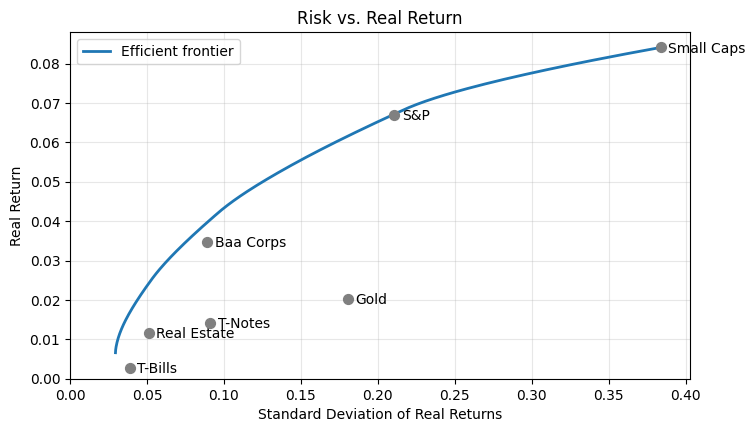

In [38]:

def efrontier(plot_ef_df,
              assets_df,
              ret_label='model_return',
              std_label='model_std',
              xlabel="Standard Deviation of Real Returns",
              ylabel="Real Return",
              title=None,
             ):

    plt.figure(figsize=(8, 4.5))

    # Plot efficient frontier
    plt.plot(plot_ef_df[std_label], plot_ef_df[ret_label], label='Efficient frontier', linewidth=2)
    plt.xlim(left=0, right=max(plot_ef_df[std_label]) * 1.05)
    plt.ylim(bottom=min(0, min(assets_df['ret'])))   # could be negative return assets

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plot_title = f"Risk vs. Real Return" if title is None else title
    plt.title(plot_title)

    plt.scatter(assets_df['std'], assets_df['ret'], color='gray', s=50, zorder=5)

    xoffset = 0.005
    yoffset = 0.0015
    for row in assets_df.itertuples():
        # print(row.Index, row.ret, row.std)
        plt.annotate(row.Index, xy=(row.std + xoffset, row.ret + yoffset),
                    xycoords='data', horizontalalignment='left',
                    verticalalignment='top')

    plt.legend(loc='best')
    plt.grid(alpha=0.3)

efrontier(plot_ef_df,
          assets_df,
          ret_label='model_return',
          std_label='model_std',
          xlabel="Standard Deviation of Real Returns",
          ylabel="Real Return",
          title=None)


In [39]:
plot_ef_df = add_historical_metrics(plot_ef_df, plot_returns_df, labels)
plot_ef_df.head()


,S&P,Small Caps,T-Bills,T-Notes,Baa Corps,Real Estate,Gold,model_return,model_std,hist_return,hist_std
0,0.000000,0.000000,0.597232,-0.000000,-0.000000,0.360788,0.041979,0.006602,0.029533,0.007684,0.028850
1,0.004306,0.000000,0.583661,-0.000000,-0.000000,0.367325,0.044708,0.006977,0.029573,0.008184,0.028891
2,0.009400,0.000000,0.574084,-0.000000,-0.000000,0.369881,0.046635,0.007352,0.029656,0.008684,0.028967
3,0.014494,0.000000,0.564508,-0.000000,-0.000000,0.372437,0.048561,0.007728,0.029780,0.009183,0.029083
4,0.016539,0.000000,0.552715,-0.000000,0.006647,0.374552,0.049547,0.008103,0.029937,0.009630,0.029244


In [40]:
# use geometric mean returns
assets2=geometric_mean.loc[geometric_mean.index.isin(labels)].copy()
assets2.columns=['ret','std']
assets2


,ret,std
S&P,0.067000,0.193954
Small Caps,0.084081,0.372102
T-Bills,0.002675,0.038017
T-Notes,0.014209,0.088987
Baa Corps,0.034818,0.088440
Real Estate,0.011557,0.049934
Gold,0.020178,0.186131


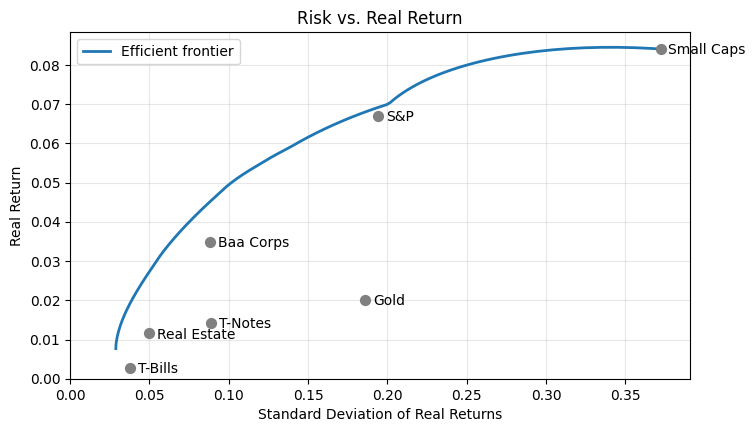

In [41]:
# use historically calculated returns and SDs

efrontier(plot_ef_df,
          assets2,
          ret_label='hist_return',
          std_label='hist_std',
          xlabel="Standard Deviation of Real Returns",
          ylabel="Real Return",
          title=None)

In [42]:
plot_ef_df[labels].mean()

S&P           0.342599
Small Caps    0.117527
T-Bills       0.075168
T-Notes       0.000000
Baa Corps     0.264780
Real Estate   0.154010
Gold          0.045916
dtype: float64

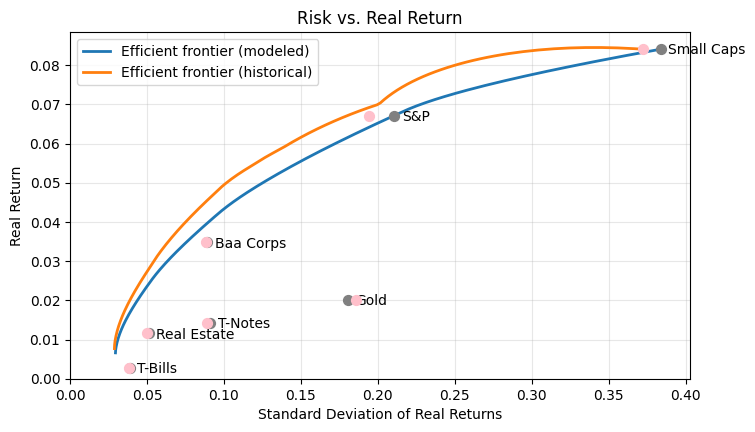

In [43]:
title=None
plt.figure(figsize=(8, 4.5))

# Plot efficient frontier
plt.plot(plot_ef_df['model_std'], plot_ef_df['model_return'], label='Efficient frontier (modeled)', linewidth=2)
plt.plot(plot_ef_df['hist_std'], plot_ef_df['hist_return'], label='Efficient frontier (historical)', linewidth=2)

plt.xlim(left=0, right=max(plot_ef_df['model_std']) * 1.05)
plt.ylim(bottom=min(0, min(assets_df['ret'])))   # could be negative return assets

plt.xlabel("Standard Deviation of Real Returns")
plt.ylabel("Real Return")

plot_title = f"Risk vs. Real Return" if title is None else title
plt.title(plot_title)

plt.scatter(assets_df['std'], assets_df['ret'], color='gray', s=50, zorder=5)
plt.scatter(assets2['std'], assets2['ret'], color='pink', s=50, zorder=5)

xoffset = 0.005
yoffset = 0.0015
for row in assets_df.itertuples():
    # print(row.Index, row.ret, row.std)
    plt.annotate(row.Index, xy=(row.std + xoffset, row.ret + yoffset),
                xycoords='data', horizontalalignment='left',
                verticalalignment='top')

plt.legend(loc='best')
plt.grid(alpha=0.3)

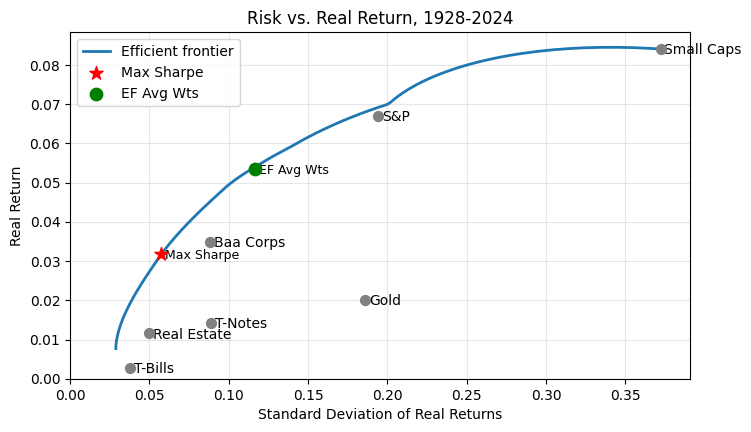

Max Sharpe Portfolio:
Real Return:  3.17%
SD:           5.74%
Sharpe Ratio: 0.552
S&P: 11.0%
Baa Corps: 41.0%
Real Estate: 39.1%
Gold: 8.8%
Average over entire efficient frontier:
Real Return:  5.34%
SD:           11.65%
Sharpe Ratio: 0.458
S&P: 34.3%
Small Caps: 11.8%
T-Bills: 7.5%
Baa Corps: 26.5%
Real Estate: 15.4%
Gold: 4.6%


In [44]:
portmetrics = plot_efrontier(plot_ef_df, plot_returns_df, assets2)


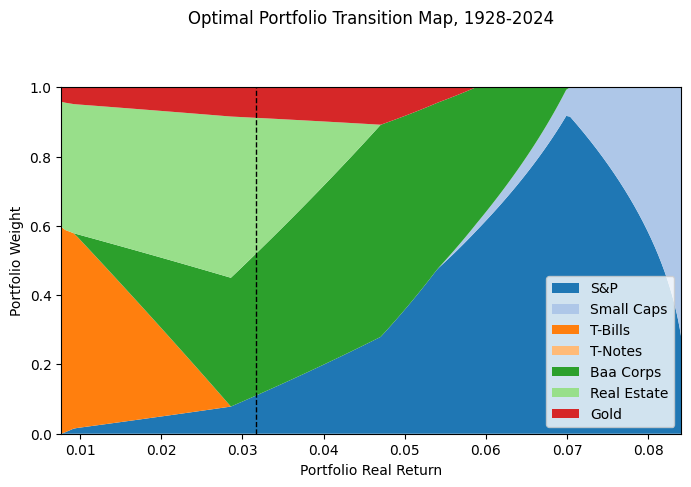

In [45]:
transition_map(plot_ef_df, asset_labels=df.columns,
              startyear=df.index[0], endyear=df.index[-1],
              max_sharpe_return=portmetrics.max_sharpe_return)


In [ ]:
# midwit portfolio is average across all optimal portfolios
plot_ef_df[labels].mean()


## 1967 - present , with TIPS proxy

In [54]:
df = df.loc[1967:]
df["TIPS"] = 0
# reorder  for chart
df = df[[ 'S&P', 'Small Caps', 'T-Notes', 'Baa Corps', 'TIPS', 'Real Estate', 'Gold', 'T-Bills' ]]
labels = df.columns
df.head()

,S&P,Small Caps,T-Notes,Baa Corps,TIPS,Real Estate,Gold,T-Bills
Year,,,,,,,,
1967,0.183579,0.743817,-0.045875,-0.021030,0,-0.007044,-0.035079,0.012096
1968,0.056573,0.428251,-0.013896,0.001197,0,-0.005611,0.071443,0.005883
1969,-0.146136,-0.461351,-0.111569,-0.080587,0,0.007478,-0.011228,0.004428
1970,-0.019215,-0.264928,0.100698,0.000751,0,0.024748,-0.153449,0.007744
1971,0.100825,0.120494,0.061230,0.098900,0,0.009432,0.122239,0.010288


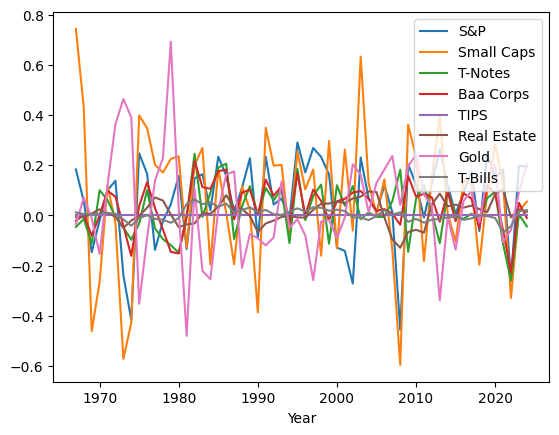

In [55]:
df.plot.line();


In [56]:
# Arithmetic means of log diff real returns
df.mean()

S&P           0.062762
Small Caps    0.065669
T-Notes       0.016775
Baa Corps     0.037962
TIPS          0.000000
Real Estate   0.012442
Gold          0.035322
T-Bills       0.004595
dtype: float64

In [57]:
# Compute covariance matrix and optimization parameters
covariance_matrix = np.cov(df.transpose())
n_assets = covariance_matrix.shape[0]
mean_return = df.mean().values
asset_vols = np.sqrt(covariance_matrix.diagonal())

# Display summary
summary_df = pd.DataFrame([mean_return, asset_vols], columns=labels)
summary_df['metric'] = ['real return', 'volatility']
summary_df.set_index('metric')


,S&P,Small Caps,T-Notes,Baa Corps,TIPS,Real Estate,Gold,T-Bills
metric,,,,,,,,
real return,0.062762,0.065669,0.016775,0.037962,0.000000,0.012442,0.035322,0.004595
volatility,0.169071,0.271181,0.101411,0.089085,0.000000,0.048917,0.201367,0.024705


In [58]:
# Solve max return portfolio (corner solution, max return asset)
w = cp.Variable(n_assets)
ret = mean_return.T @ w
vol = cp.quad_form(w, covariance_matrix)

prob = cp.Problem(
    cp.Maximize(ret),
    [cp.sum(w) == 1, w >= 0]
)
prob.solve()

if prob.status not in ['optimal', 'optimal_inaccurate']:
    raise ValueError(f"Optimization failed with status: {prob.status}")

wts = [float(f'{v:.4f}') for v in w.value]
_, maxretstd = compute_historical_metrics(df, np.array(wts))
maxretvol = vol.value
print(f"max variance (from weights):      {maxretstd**2}")
print(f"max variance (from optimization): {maxretvol}")
maxret = ret.value

print("Max return portfolio weights:")
pd.DataFrame([wts], columns=labels)

max variance (from weights):      0.07353903718609317
max variance (from optimization): 0.07353903594037275
Max return portfolio weights:


,S&P,Small Caps,T-Notes,Baa Corps,TIPS,Real Estate,Gold,T-Bills
0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [59]:
# Solve min volatility portfolio (other corner solution)
# 100% TIPS

prob = cp.Problem(
    cp.Minimize(vol),
    [cp.sum(w) == 1, w >= 0]
)
prob.solve()

if prob.status not in ['optimal', 'optimal_inaccurate']:
    raise ValueError(f"Optimization failed with status: {prob.status}")

wts = [float(f'{v:.6f}') for v in w.value]
minvol = vol.value
print(f"Minimum vol: {minvol}")
minvolret = ret.value

print("Min volatility portfolio weights:")
pd.DataFrame([wts], columns=labels)

Minimum vol: 1.3849417881796094e-39
Min volatility portfolio weights:


,S&P,Small Caps,T-Notes,Baa Corps,TIPS,Real Estate,Gold,T-Bills
0,-0.000000,-0.000000,-0.000000,-0.000000,1.000000,-0.000000,0.000000,-0.000000


In [60]:
%%time
# Solve efficient frontier using standard Markowitz formulation
# For each target return level, minimize volatility

# Generate return targets (linear spacing from min to max return)
ret_targets = np.linspace(minvolret, maxret, NPOINTS)

# Prepare parameters for parallel processing
params_list = [(target_ret, mean_return, covariance_matrix, n_assets) for target_ret in ret_targets]

# Solve in parallel or single-thread
if USE_PARALLEL:
    with Pool(processes=NPROCESSES) as pool:
        result_values = pool.map(solve_portfolio_optimization, params_list)
    results_dict = dict(zip(ret_targets, result_values))
else:
    results_dict = {}
    for params in params_list:
        target_ret = params[0]
        results_dict[target_ret] = solve_portfolio_optimization(params)

for target_ret, result in results_dict.items():
      if result is None:
          raise ValueError(f"Optimization failed for target_return={target_ret}")
      if not isinstance(result, OptimizationResult):
          raise ValueError(f"Unexpected result type for target_return={target_ret}")


CPU times: user 367 ms, sys: 16.6 ms, total: 383 ms
Wall time: 389 ms


In [61]:
# Build scenarios DataFrame
plot_ef_df = pd.DataFrame([result.weights for result in results_dict.values()], columns=labels)

plot_ef_df['model_return'] = [result.return_val for result in results_dict.values()]
plot_ef_df['model_std'] = [result.std_dev for result in results_dict.values()]

# Add historical metrics
# plot_ef_df = add_historical_metrics(plot_ef_df, plot_returns_df, labels)
# weights for each asset, plus average return, standard deviation (log diff basis)
plot_ef_df.tail()


,S&P,Small Caps,T-Notes,Baa Corps,TIPS,Real Estate,Gold,T-Bills,model_return,model_std
195,0.454093,0.545907,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.064349,0.209171
196,0.340569,0.659431,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.064679,0.223018
197,0.227046,0.772954,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.065009,0.238110
198,0.113523,0.886477,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.065339,0.254225
199,0.000000,1.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.065669,0.271181


In [64]:
log_diff_df = df
log_diff_df[labels].head()

,S&P,Small Caps,T-Notes,Baa Corps,TIPS,Real Estate,Gold,T-Bills
Year,,,,,,,,
1967,0.183579,0.743817,-0.045875,-0.021030,0,-0.007044,-0.035079,0.012096
1968,0.056573,0.428251,-0.013896,0.001197,0,-0.005611,0.071443,0.005883
1969,-0.146136,-0.461351,-0.111569,-0.080587,0,0.007478,-0.011228,0.004428
1970,-0.019215,-0.264928,0.100698,0.000751,0,0.024748,-0.153449,0.007744
1971,0.100825,0.120494,0.061230,0.098900,0,0.009432,0.122239,0.010288


In [65]:
log_diff_df[labels].mean()


S&P           0.062762
Small Caps    0.065669
T-Notes       0.016775
Baa Corps     0.037962
TIPS          0.000000
Real Estate   0.012442
Gold          0.035322
T-Bills       0.004595
dtype: float64

In [66]:
mean_return = log_diff_df[labels].mean().values
asset_vols = log_diff_df[labels].std().values
print(asset_vols)
mean_return

[0.16907109 0.27118082 0.10141075 0.08908543 0.         0.04891731
 0.20136727 0.0247051 ]


array([0.06276186, 0.0656687 , 0.01677477, 0.03796195, 0.        ,
       0.0124416 , 0.03532241, 0.00459515])

In [67]:
mean_return = df.mean().values
asset_vols = np.sqrt(covariance_matrix.diagonal())
print(asset_vols)
mean_return


[0.16907109 0.27118082 0.10141075 0.08908543 0.         0.04891731
 0.20136727 0.0247051 ]


array([0.06276186, 0.0656687 , 0.01677477, 0.03796195, 0.        ,
       0.0124416 , 0.03532241, 0.00459515])

In [69]:
summary_df = pd.DataFrame([mean_return, asset_vols], columns=labels)
# summary_df['metric'] = ['real return', 'volatility']
# summary_df.set_index('metric')

summary_df = summary_df.transpose()
summary_df.columns=['ret', 'std']
# make sure not obj
# summary_df['ret'] = summary_df['ret'].astype(float)
# summary_df['std'] = summary_df['std'].astype(float)
summary_df

,ret,std
S&P,0.062762,0.169071
Small Caps,0.065669,0.271181
T-Notes,0.016775,0.101411
Baa Corps,0.037962,0.089085
TIPS,0.000000,0.000000
Real Estate,0.012442,0.048917
Gold,0.035322,0.201367
T-Bills,0.004595,0.024705


In [70]:
# convert log diffs to pct change
assets_df = summary_df.copy()
assets_df['ret'] = log_diff_to_pct(np.asarray(assets_df['ret']))
assets_df['std'] = log_diff_to_pct(np.asarray(assets_df['std']))
assets_df


,ret,std
S&P,0.064773,0.184204
Small Caps,0.067873,0.311512
T-Notes,0.016916,0.106731
Baa Corps,0.038692,0.093174
TIPS,0.000000,0.000000
Real Estate,0.012519,0.050134
Gold,0.035954,0.223074
T-Bills,0.004606,0.025013


In [71]:
plot_ef_df['model_return'] = log_diff_to_pct(np.asarray(plot_ef_df['model_return']))
plot_ef_df['model_std'] = log_diff_to_pct(np.asarray(plot_ef_df['model_std']))


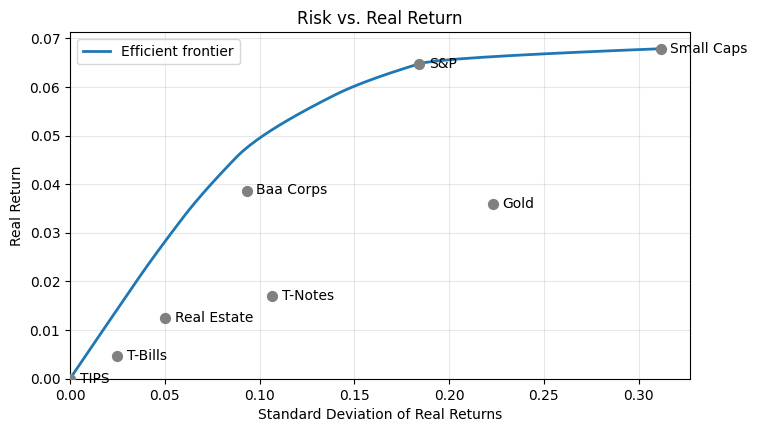

In [72]:

efrontier(plot_ef_df,
          assets_df,
          ret_label='model_return',
          std_label='model_std',
          xlabel="Standard Deviation of Real Returns",
          ylabel="Real Return",
          title=None)

In [74]:
plot_returns_df["TIPS"]=0
plot_ef_df = add_historical_metrics(plot_ef_df, plot_returns_df, labels)
plot_ef_df.head()

,S&P,Small Caps,T-Notes,Baa Corps,TIPS,Real Estate,Gold,T-Bills,model_return,model_std,hist_return,hist_std
0,-0.000000,-0.000000,-0.000000,-0.000000,1.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000
1,0.001227,-0.000000,0.000000,0.003000,0.983870,0.004515,0.001595,0.005793,0.000330,0.000573,0.000353,0.000660
2,0.002453,-0.000000,0.000000,0.005999,0.967740,0.009031,0.003190,0.011587,0.000660,0.001147,0.000706,0.001320
3,0.003680,-0.000000,0.000000,0.008999,0.951610,0.013546,0.004785,0.017380,0.000990,0.001720,0.001058,0.001980
4,0.004906,-0.000000,0.000000,0.011999,0.935481,0.018061,0.006380,0.023173,0.001321,0.002294,0.001410,0.002640


In [85]:
plot_returns_df[labels].std()

S&P           0.193954
Small Caps    0.372102
T-Notes       0.088987
Baa Corps     0.088440
TIPS          0.000000
Real Estate   0.049934
Gold          0.186131
T-Bills       0.038017
dtype: float64

In [91]:
n_periods=len(plot_returns_df)
geometric_mean = pd.DataFrame([(plot_returns_df[labels]+1).prod()**(1/n_periods)-1,
                               plot_returns_df[labels].std()]).transpose()
geometric_mean.columns=['ret', 'std']
geometric_mean

,ret,std
S&P,0.067000,0.193954
Small Caps,0.084081,0.372102
T-Notes,0.014209,0.088987
Baa Corps,0.034818,0.088440
TIPS,0.000000,0.000000
Real Estate,0.011557,0.049934
Gold,0.020178,0.186131
T-Bills,0.002675,0.038017


In [92]:
# use geometric mean returns
assets2=geometric_mean.loc[geometric_mean.index.isin(labels)].copy()
assets2.columns=['ret','std']
assets2

,ret,std
S&P,0.067000,0.193954
Small Caps,0.084081,0.372102
T-Notes,0.014209,0.088987
Baa Corps,0.034818,0.088440
TIPS,0.000000,0.000000
Real Estate,0.011557,0.049934
Gold,0.020178,0.186131
T-Bills,0.002675,0.038017


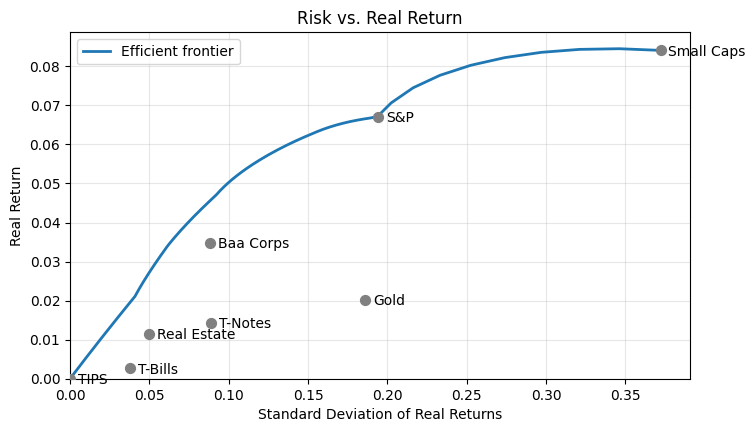

In [93]:

efrontier(plot_ef_df,
          assets2,
          ret_label='hist_return',
          std_label='hist_std',
          xlabel="Standard Deviation of Real Returns",
          ylabel="Real Return",
          title=None)


In [94]:
plot_ef_df[labels].mean()


S&P           0.271676
Small Caps    0.024592
T-Notes       0.000000
Baa Corps     0.209860
TIPS          0.157492
Real Estate   0.129461
Gold          0.118473
T-Bills       0.088446
dtype: float64

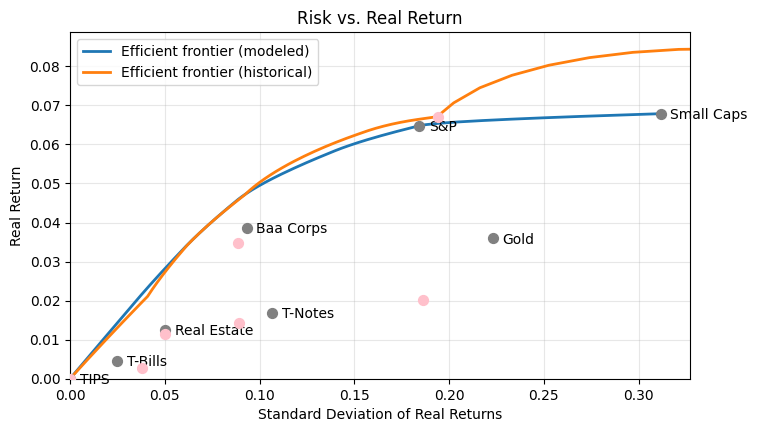

In [95]:
title=None
plt.figure(figsize=(8, 4.5))

# Plot efficient frontier
plt.plot(plot_ef_df['model_std'], plot_ef_df['model_return'], label='Efficient frontier (modeled)', linewidth=2)
plt.plot(plot_ef_df['hist_std'], plot_ef_df['hist_return'], label='Efficient frontier (historical)', linewidth=2)

plt.xlim(left=0, right=max(plot_ef_df['model_std']) * 1.05)
plt.ylim(bottom=min(0, min(assets_df['ret'])))   # could be negative return assets

plt.xlabel("Standard Deviation of Real Returns")
plt.ylabel("Real Return")

plot_title = f"Risk vs. Real Return" if title is None else title
plt.title(plot_title)

plt.scatter(assets_df['std'], assets_df['ret'], color='gray', s=50, zorder=5)
plt.scatter(assets2['std'], assets2['ret'], color='pink', s=50, zorder=5)

xoffset = 0.005
yoffset = 0.0015
for row in assets_df.itertuples():
    # print(row.Index, row.ret, row.std)
    plt.annotate(row.Index, xy=(row.std + xoffset, row.ret + yoffset),
                xycoords='data', horizontalalignment='left',
                verticalalignment='top')

plt.legend(loc='best')
plt.grid(alpha=0.3)


In [115]:
labels=['Small Caps', 'S&P', 'T-Notes', 'TIPS',
       'T-Bills','Real Estate','Baa Corps',  'Gold', ]


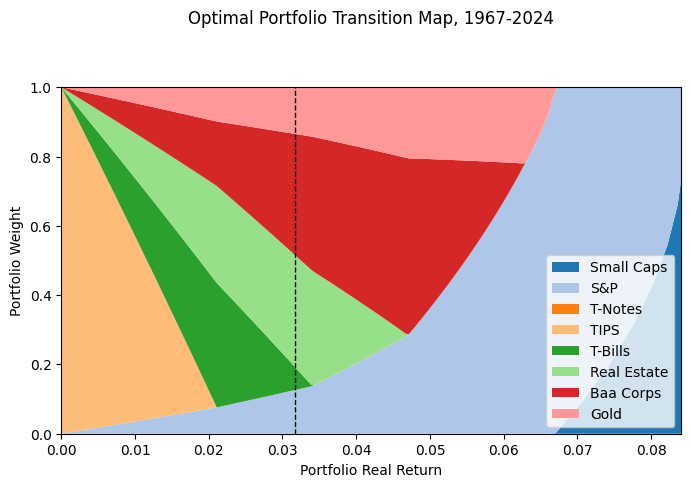

In [116]:
transition_map(plot_ef_df, asset_labels=labels,
               startyear=df.index[0], endyear=df.index[-1],
               max_sharpe_return=portmetrics.max_sharpe_return)
